**Анализ поведения пользователей сайта и A/A/B-эксперимент по изменению шрифта на сайте**

**Описание исследования**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. А также дизайнеры захотели поменять шрифты во всём приложении, но менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.


**Цель исследования**

Разобраться, как ведут себя пользователи вашего мобильного приложения, и определить какой шрифт для пользователей лучше.


**Задачи исследования**
- Изучить воронку продаж и узнать, как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и каких именно
- Исследовать результаты A/A/B-эксперимента для определения, какой шрифт лучше

**Описание данных**

В нашем распоряжении датасет logs_exp.csv.

Каждая запись в логе — это действие пользователя, или событие.

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Данное исследование разделим на несколько частей:**


1.  <a href='#info'> Изучение общей информации </a> 


2. <a href='#data'> Подготовка данных </a> 


3. <a href='#learn'> Изучение и проверка данных </a> 



4. <a href='#funnel'> Изучение воронки событий </a> 



5. <a href='#experiment'> Изучение результатов эксперимента </a> 


6. <a href='#conclusion'> Выводы </a> 




Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

# Загрузка и подготовка данных к анализу
<a id='info'></a> 

In [1]:
import pandas as pd

# построение графиков
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# построение воронок
import plotly.express as px
from plotly import graph_objects as go

# проверка гипотез (статистической значимости)
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv',sep='\t')
    
except:
    df  = pd.read_csv("C:/Users/schap/Yandex Practicum/проекты/Сборный проект 2/logs_exp.csv",sep='\t')


Посмотрим на несколько рандомных строк загруженного датасета, а также информацию о столбцах на предмет пропусков и типа данных:

In [3]:
display(df.sample(5))
df.info()

EventName         DeviceIDHash  EventTimestamp  ExpId
75895          CartScreenAppear  3610536745613892312      1564805573    248
241111  PaymentScreenSuccessful  7370834916791045057      1565203671    246
230104         CartScreenAppear  8404240563510634678      1565185795    248
198043         MainScreenAppear  5228868738120302850      1565101354    248
164324         MainScreenAppear  3383558428248432049      1565018196    246

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Выводы:**
1. Названия столбцов содержат заглавные буквы и не соответствуют *красивому стилю* (snake case)
2. Пропусков в столбцах нет
3. Столбец с датами `EventTimestamp` имеет некорретный тип данных

Исправим пункты 1 и 3 на следующем шаге

# Подготовка данных
<a id='data'></a> 

Переименуем столбцы в соответствии со *snake case*, а также с учётом удобства последующей работы с ними:

In [4]:
df.rename(
    columns={'EventName': 'event_name',
             'DeviceIDHash':'user_id',
             'EventTimestamp':'event_ts',
             'ExpId':'group'},
    inplace=True
)

Столбец даты и времени `event_ts` переведём в формат datetime до секунд, а также  добавим отдельный столбец только с датой (ГГГГММДД):

In [5]:
# переводим Unix timestamp в понятный формат даты с помощью Pandas datetime + указание секунд
df['event_ts'] = pd.to_datetime(df['event_ts'],unit='s')

In [6]:
# добавляем столбец с датой (ГГГГММДД)
df['event_date'] = df['event_ts'].map(pd.Timestamp.date) 
# переводим в правильный формат datetime
df['event_date'] = df['event_date'].astype('datetime64[ns]')

Проверим датасет на наличие явных дубликатов:

In [7]:
print('Явных дубликатов в таблице:',
      df.duplicated().sum(),
      '; '
      '% дубликатов в таблице:',
      '{0:.2%}'.format(df.duplicated().sum()/df.shape[0]))

Явных дубликатов в таблице: 413 ; % дубликатов в таблице: 0.17%


Найдено 413 явных дубликатов (0.17% от всех данных). Посмотрим на несколько первых строк и выгрузим одну строку на выбор подробно:

In [8]:
duplicates = df[df.duplicated()]
duplicates.head(10)

event_name              user_id            event_ts  group  \
453          MainScreenAppear  5613408041324010552 2019-07-30 08:19:44    248   
2350         CartScreenAppear  1694940645335807244 2019-07-31 21:51:39    248   
3573         MainScreenAppear   434103746454591587 2019-08-01 02:59:37    248   
4076         MainScreenAppear  3761373764179762633 2019-08-01 03:47:46    247   
4803         MainScreenAppear  2835328739789306622 2019-08-01 04:44:01    248   
5641         CartScreenAppear  4248762472840564256 2019-08-01 05:36:04    248   
5875  PaymentScreenSuccessful  6427012997733591237 2019-08-01 05:47:32    248   
7249       OffersScreenAppear  7224691986599895551 2019-08-01 06:44:06    246   
8065         CartScreenAppear  8189122927585332969 2019-08-01 07:18:49    248   
9179         MainScreenAppear  2230705996155527339 2019-08-01 07:54:47    246   

     event_date  
453  2019-07-30  
2350 2019-07-31  
3573 2019-08-01  
4076 2019-08-01  
4803 2019-08-01  
5641 2019-08-01  
5875 2019-08-01  
7249 2019-08-01  
8065 2019-08-01  
9179 2019-08-01

In [9]:
df[(df['user_id']==5613408041324010552)&(df['event_ts']=='2019-07-30 08:19:44')].sort_values(by='event_ts')

event_name              user_id            event_ts  group  \
452  MainScreenAppear  5613408041324010552 2019-07-30 08:19:44    248   
453  MainScreenAppear  5613408041324010552 2019-07-30 08:19:44    248   

    event_date  
452 2019-07-30  
453 2019-07-30

Возможно, такое и может быть из-за сбоев на сайте / из-за действий пользователя, когда действительно одновременно появляется две остнвные страницы сайт, но смысловой нагрузки для аналитики такой сбой не несёт, % таких ошибок в таблице крайне мал, поэтому удаляем дубликаты, оставив только одно зарегестрирированное для пользователя событие в каждом комплекте дубликатов:

In [10]:
df.drop_duplicates(inplace=True)

Проверим теперь, есть ли у нас пользователи одновременно в нескольких / двух группах (246, 247, 248). 
По умолчанию такого быть не должно, все пользователи должны строго разбиться на группы, чтобы можно было корректно оценивать результат A/B теста:

In [11]:
a_1 = df[df['group']==246]['user_id'].unique()
a_2 = df[df['group']==247]['user_id'].unique()
b = df[df['group']==248]['user_id'].unique()

dub_gr = []
for x in a_1:
    if x in a_2 or x in b:
        dub_gr.append(x)

for x in a_2:
    if x in a_1 or x in b:
        dub_gr.append(x)
        
print('Пользователей в нескольких группах:', len(dub_gr))
        

Пользователей в нескольких группах: 0


**Выводы:**
1. Столбцы переименованы в соответствии со snake case, а также с точки зрения удобства использования
2. Столбец с датой и временем приведён в соответствующий тип данных, а также добавлен столбец только с датой без времени
3. В датасете найдены и удалены дубликаты
4. ПОльзователи корректно распредлены между группами (каждый пользователь только в одной группе теста)

# Изучение и проверка данных
<a id='learn'></a> 

Изучим предоставленную в логе информацию по пунктам

## Cколько всего событий в логе

In [12]:
print('В логе:', df.shape[0], 'событий')

В логе: 243713 событий


Названия событий уникальны и выглядят логичными:

In [13]:
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

## Сколько всего пользователей в логе

In [14]:
df['user_id'].nunique()

7551

Мы можем проанализировать поведение более 7.5 тыс. пользователей, каждый из которых корректно распределён только в одну из групп теста.

## Сколько в среднем событий приходится на пользователя

In [15]:
# посчитаем количество событий у каждого уникального пользователя
event_avg = df.groupby('user_id',as_index=False
                      ).agg({'event_name':'count'}
                           )
# переименуем колонки сгруппированной таблицы в соответствии с данными, содержащимися в них
event_avg.columns = ['user_id', 'events_number']

# посчитаем среднее количество заказов на одного пользователя
events_number_avg = sum(event_avg['events_number'])/event_avg.shape[0]

print('На одного пользователя приходится  среднем:','{0:0.1f}'.format(events_number_avg), 'события')

На одного пользователя приходится  среднем: 32.3 события


Посмотрим, как соотносится такое среднее с другими параметрами данных в сгруппированной таблице `event_avg`:

In [16]:
event_avg['events_number'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: events_number, dtype: float64

**Выводы:**
1. Мы видим большой разброс количества заказов на пользователя: от 1 до 2 307
2. Медиана (20 заказов на пользователя) сильно отличается от среднего значения заказов на пользователя (32.3). Это знаит, что несколько пользователей с очень большим количеством заказов искажают средние показатели
3. Пользователей с большим количеством заказов необходимо изучить подробнее (ниже)

Визуализируем распределение количества событий по пользователям:

Text(0.5, 1.0, 'Распределение пользователей по количеству событий')

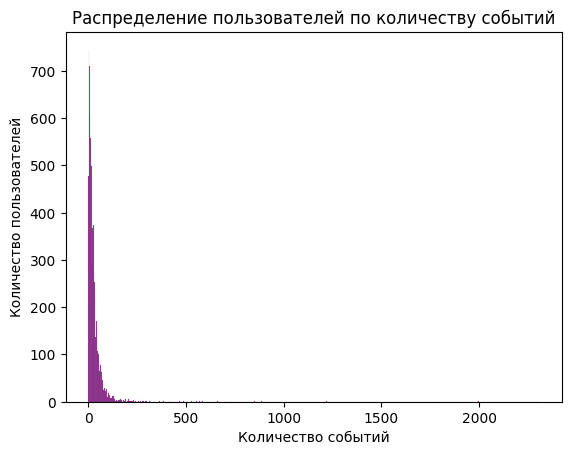

In [17]:
sns.histplot(event_avg['events_number'],color='purple') 
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по количеству событий')

В основном на пользователя приходится до 250 событий.
Построим точечный график распределения количества событий на пользователя:

<AxesSubplot:title={'center':'Количество событий пользователя'}, xlabel='Уникальный идентификатор пользователя', ylabel='Количество событий'>

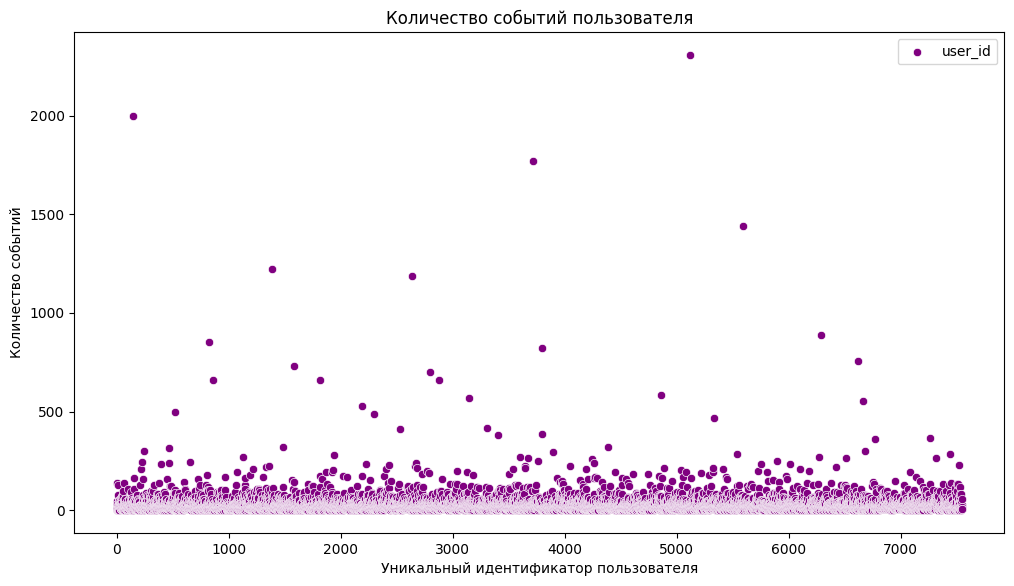

In [18]:
plt.figure(figsize=(12,6.5))
plt.title('Количество событий пользователя')
plt.xlabel('Уникальный идентификатор пользователя')
plt.ylabel('Количество событий')
sns.scatterplot(data=event_avg['events_number'],label='user_id',color='purple')  

Ограничим количество событий у пользователя до 250:

<AxesSubplot:title={'center':'Количество событий пользователя'}, xlabel='Индекс пользователя', ylabel='Количество событий'>

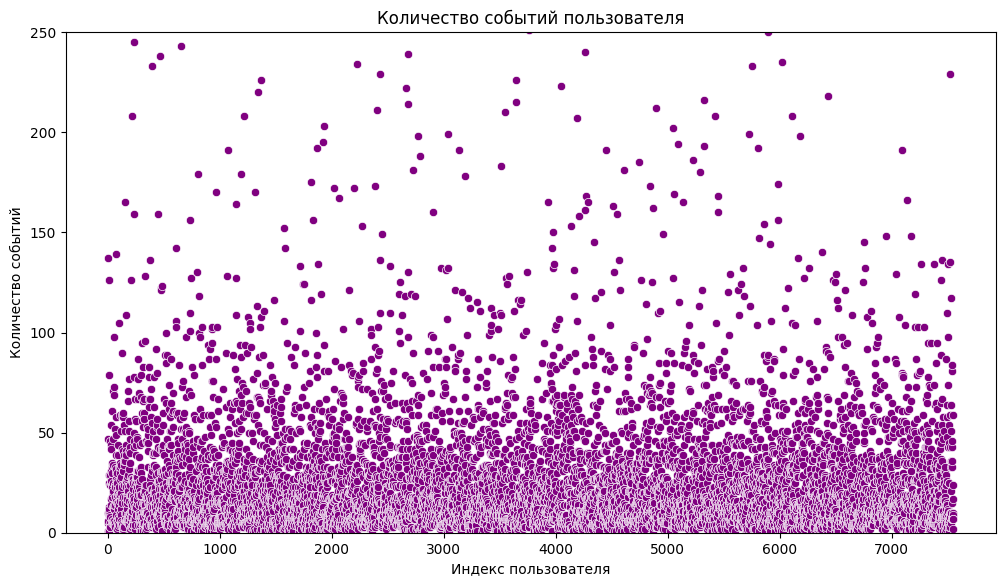

In [19]:
plt.figure(figsize=(12,6.5))
plt.title('Количество событий пользователя')
plt.xlabel('Индекс пользователя')
plt.ylabel('Количество событий')
plt.ylim(0,250)
sns.scatterplot(data=event_avg['events_number'],color='purple') 

Теперь наглядно видно, что в основном у пользователей сайта до 100 событий, однако оценим это точнее, посчитав выборочные перцентили количества событий на одного пользователя:

In [20]:
print(np.percentile(event_avg['events_number'], [90, 95, 99])) 

[ 64.   89.  200.5]


In [21]:
print(
    'Удалим:',
    len(event_avg[event_avg['events_number']>np.percentile(event_avg['events_number'], [90, 95, 99])[2]]),
    'пользователей'
)

Удалим: 76 пользователей


**Выводы:**
1. 5% пользователей имеют более 89 событий
2. Лишь 1% пользователей имеют более 200-201 события
3. Чтобы избежать искажения аналитики тех или иных показателей **установим границу отсечения аномальных пользователей на уровне 99-го перцентиля**. 76 пользователей будут удалены.

Удалённые пользователи делали много покупок (значения в столбце `PaymentScreenSuccessful`) однако такое может не повториться, поэтому можем передать id 'vip'пользователей для изучения в отдел маркетинга, но для проведения A/B теста избавимся от них.

In [22]:
payments = df.pivot_table(
    values='group',
    columns='event_name',
    index='user_id',
    aggfunc='count',
    margins=True,
    margins_name='total'
).reset_index().sort_values(by='PaymentScreenSuccessful',ascending=False)
payments[payments['total']>np.percentile(event_avg['events_number'], [90, 95, 99])[2]].head(10)


event_name              user_id  CartScreenAppear  MainScreenAppear  \
7551                      total           42668.0          119101.0   
5116        6304868067479728361            1100.0              46.0   
147          197027893265565660             932.0              93.0   
3714        4623191541214045580             778.0              91.0   
1391        1754140665440434215             596.0              10.0   
2641        3337471580007169353             527.0              57.0   
5590        6932517045703054087             417.0             112.0   
6294        7738058666231999878             413.0              38.0   
3801        4713748699910253089             376.0              23.0   
822         1055544042902443290             379.0              52.0   

event_name  OffersScreenAppear  PaymentScreenSuccessful  Tutorial   total  
7551                   46808.0                  34118.0    1018.0  243713  
5116                      76.0                   1085.0       NaN    2307  
147                      107.0                    866.0       NaN    1998  
3714                     137.0                    762.0       NaN    1768  
1391                      45.0                    570.0       NaN    1221  
2641                      77.0                    525.0       NaN    1186  
5590                     509.0                    401.0       NaN    1439  
6294                      68.0                    368.0       1.0     888  
3801                      59.0                    366.0       NaN     824  
822                       58.0                    365.0       NaN     854

## Период данных в логе

Посмотрим, какой период данных представлен в логе. 

In [23]:
print('Минимальная дата в логе:', min(df['event_ts']))
print('Максимальная дата в логе:', max(df['event_ts']))

Минимальная дата в логе: 2019-07-25 04:43:36
Максимальная дата в логе: 2019-08-07 21:15:17


В логе содержатся данные за период с 25 июля по 7 августа 2019 года. Однако нужно оценить, как распределены события по датам. Возможно, в начале сбора данных событий будет меньше. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросьте более старые.

Text(0, 0.5, 'Количество событий')

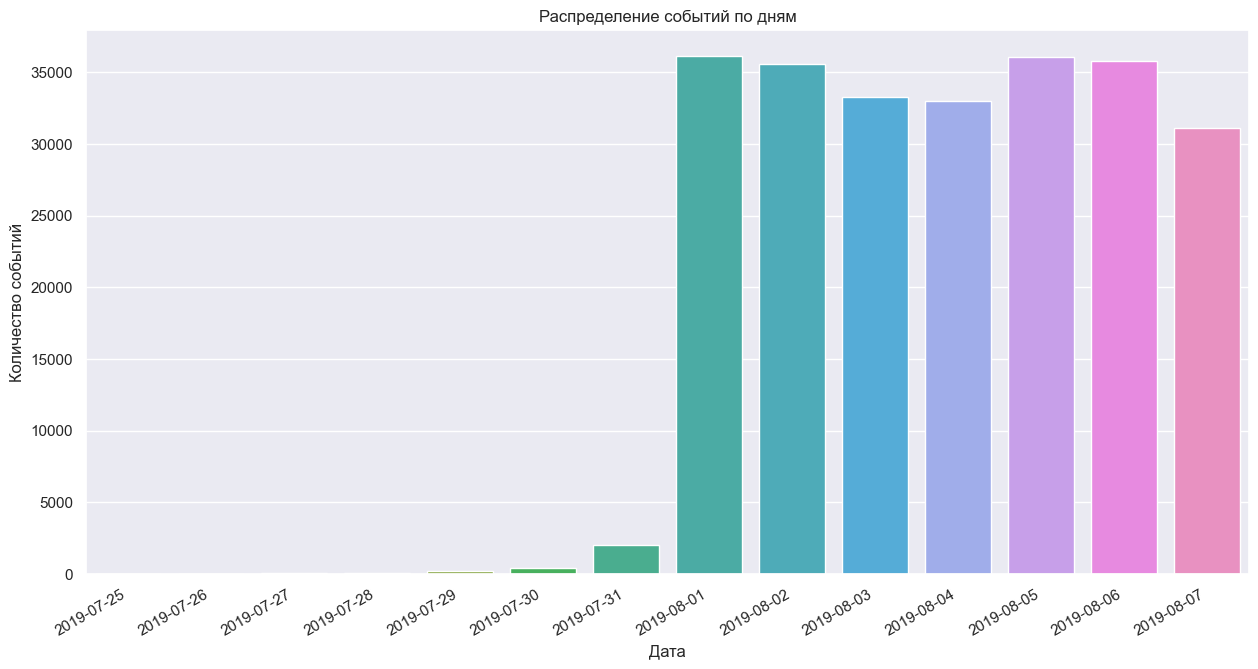

In [24]:
# сгруппируем количество событий по датам, чтобы оценить распределение
time_group = df.groupby('event_date')['event_name'].count().reset_index()

# формат даты  для корректных подписей осей

time_group['event_date'] = time_group['event_date'].dt.strftime('%Y-%m-%d')

# построим диаграмму распределения событий по датам
sns.set(rc={'figure.figsize':(15,8)})
sns.barplot(data = time_group, x='event_date', y='event_name')

plt.gcf().autofmt_xdate()

plt.title('Распределение событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')

**Вывод:**
Из диаграммы распределения событий по датам видно, что на самом деле мы располагаем данными за неделю с 1 по 7-ое августа 2019 года. В этом периоде количество собыйти по дням примерно равно, в отличии от начала эксперимента, когда данных почти нет, либо очень мало (с 25 июля по 31 июля 2019 года). Поэтому начало экспреимента мы отбросим, оставив 1-7 августа 2019 года для анализа.

In [25]:
df

event_name              user_id            event_ts  \
0              MainScreenAppear  4575588528974610257 2019-07-25 04:43:36   
1              MainScreenAppear  7416695313311560658 2019-07-25 11:11:42   
2       PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47   
3              CartScreenAppear  3518123091307005509 2019-07-25 11:28:47   
4       PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42   
...                         ...                  ...                 ...   
244121         MainScreenAppear  4599628364049201812 2019-08-07 21:12:25   
244122         MainScreenAppear  5849806612437486590 2019-08-07 21:13:59   
244123         MainScreenAppear  5746969938801999050 2019-08-07 21:14:43   
244124         MainScreenAppear  5746969938801999050 2019-08-07 21:14:58   
244125       OffersScreenAppear  5746969938801999050 2019-08-07 21:15:17   

        group event_date  
0         246 2019-07-25  
1         246 2019-07-25  
2         248 2019-07-25  
3         248 2019-07-25  
4         248 2019-07-25  
...       ...        ...  
244121    247 2019-08-07  
244122    246 2019-08-07  
244123    246 2019-08-07  
244124    246 2019-08-07  
244125    246 2019-08-07  

[243713 rows x 5 columns]

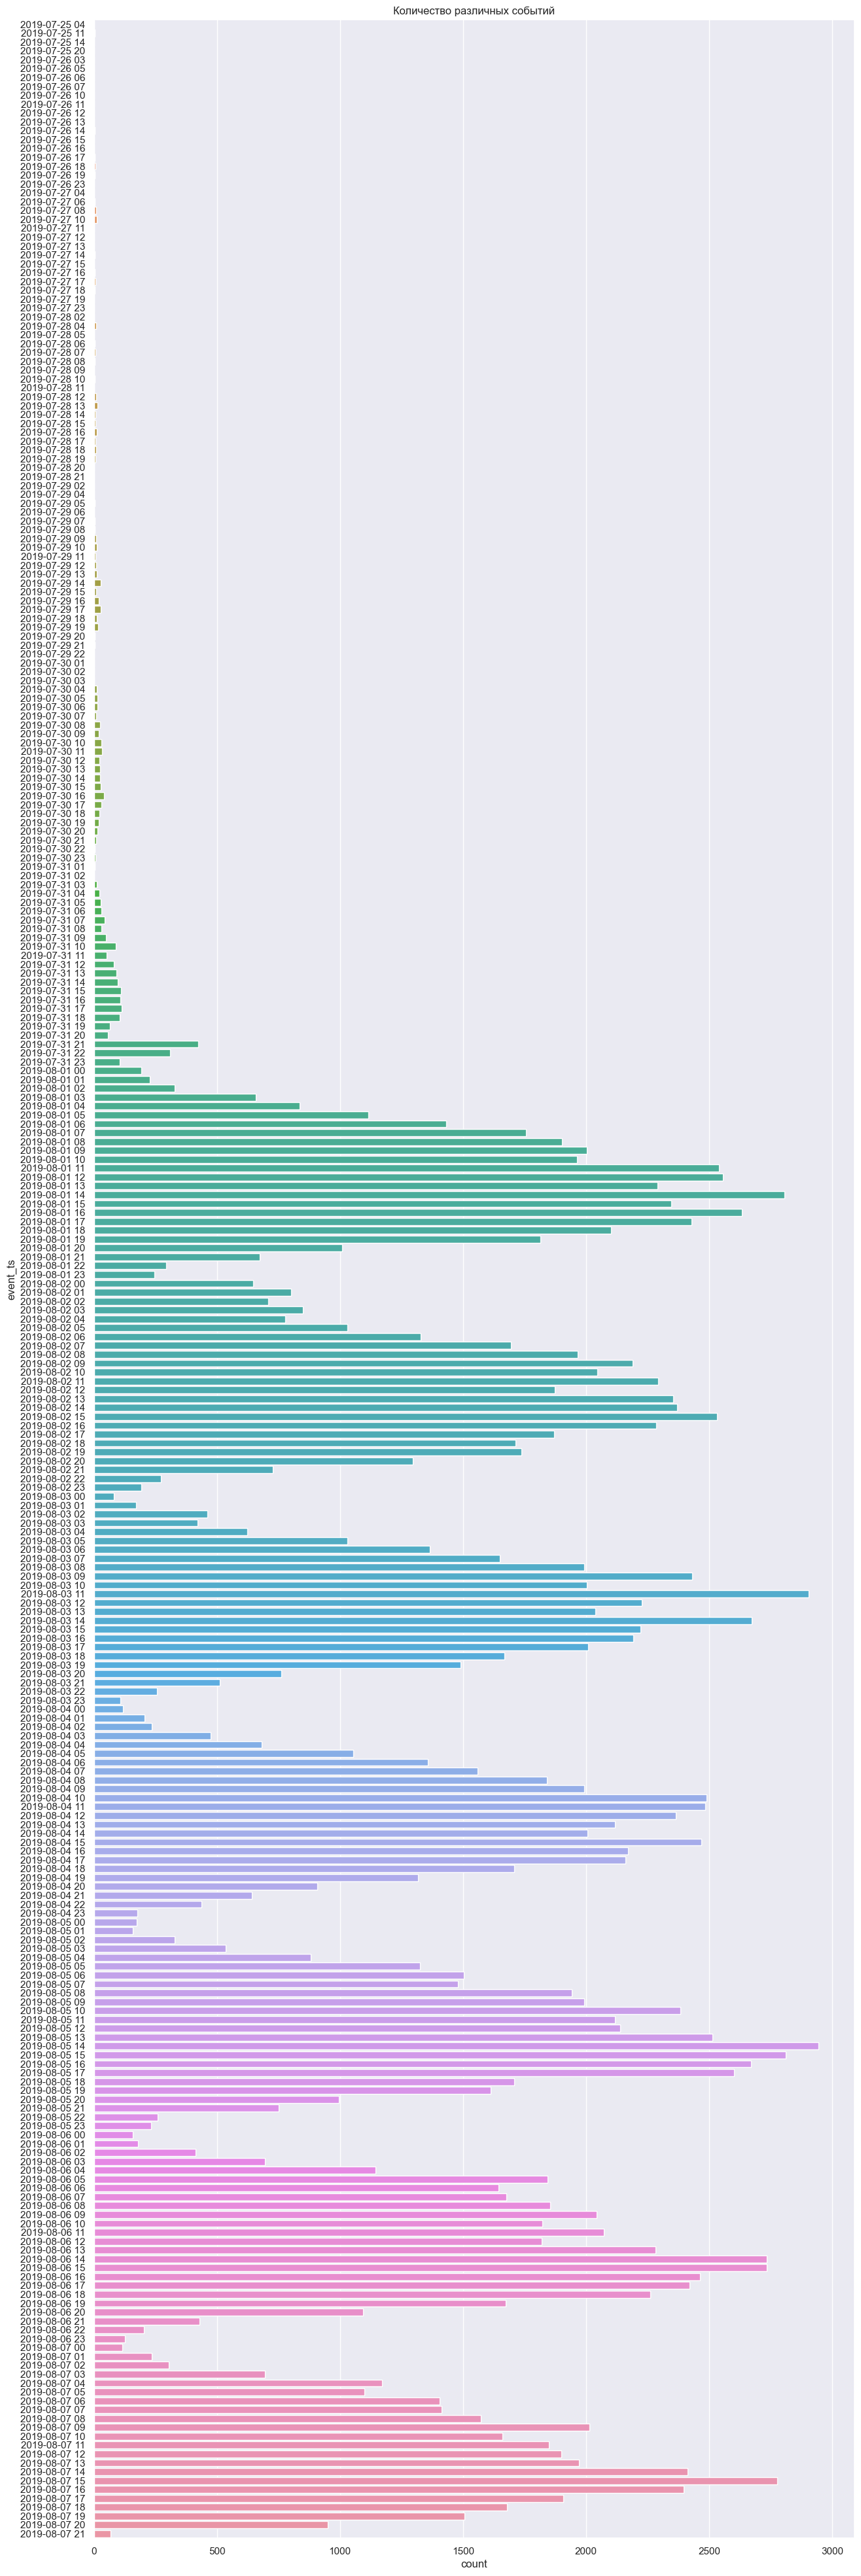

In [26]:
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=df['event_ts'].dt.strftime('%Y-%m-%d %H'), data=df, dodge=False)
ax.set_title('Количество различных событий')
plt.show()

## Актуализация временного диапазона лога


In [27]:
# создадим новый актуальный датафрейм на случай, если понадобится обратиться к старому
df_actual = df[df['event_date']>='2019-08-01']

In [28]:
print(
    'Потеряли событий:', 
      df.shape[0]-df_actual.shape[0], 
      'или', 
      '{0:.2%}'.format((df.shape[0]-df_actual.shape[0])/df.shape[0])
)

print(
    'Потеряли пользователей:', 
      df['user_id'].nunique()-df_actual['user_id'].nunique(), 
      'или', 
      '{0:.2%}'.format((df['user_id'].nunique()-df_actual['user_id'].nunique())/df['user_id'].nunique())
)

Потеряли событий: 2826 или 1.16%
Потеряли пользователей: 17 или 0.23%


Проверим, что у нас есть пользователи из всех трёх экспериментальных групп:

In [29]:
group_check = df_actual.groupby(by='group').agg({'event_name':'count','user_id':'nunique'})
group_check.rename(
    columns={'event_name':'events_number','user_id':'unique_users'},
    inplace=True
)
group_check

events_number  unique_users
group                             
246            79302          2484
247            77022          2513
248            84563          2537

 **Выводы:**
 - в актуализированном датасете присутствуют все 3 группы пользователей
 - количество событий в группах распределено не совсем равными долями (группа 248 на 9% больше, чем группа 247, например), однако количество пользователей в группах практически равно (не более 2% разницы), что говорит о корректном проведении А/B теста

**Выводы:**
- мы потеряли всего 17 пользователей (0.2%) и 2.8 тыс. событий (1.2%), актуализировав временной диапазон датасета
- пользователи всех трёх групп присутствуют в датасете

# Изучение воронки событий
<a id='funnel'></a> 

## События в логах (распределение по частоте)

Посмотрим, какие события есть в логах и как часто они встречаются:

In [30]:
events_log = df_actual.pivot_table(
    values='group',
    index='event_name',
    aggfunc='count'    
).reset_index()

events_log.rename(columns={'group': 'frequency'},inplace=True)
                           
events_log['%'] = (events_log['frequency']/sum(events_log['frequency'])).apply('{:.1%}'.format)

events_log.sort_values(by='frequency',ascending=False)

event_name  frequency      %
1         MainScreenAppear     117328  48.7%
2       OffersScreenAppear      46333  19.2%
0         CartScreenAppear      42303  17.6%
3  PaymentScreenSuccessful      33918  14.1%
4                 Tutorial       1005   0.4%

Text(0, 0.5, 'Название события')

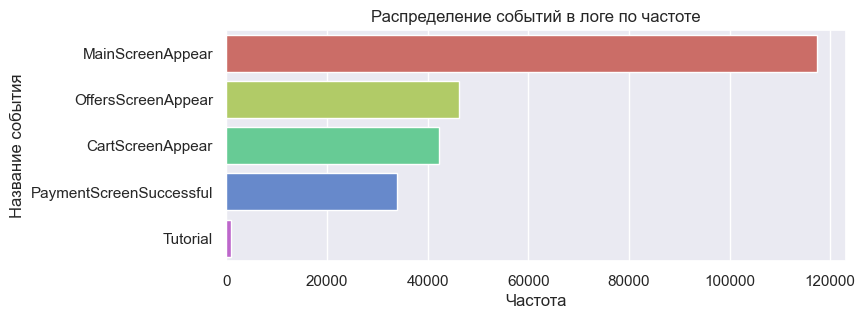

In [31]:
sns.set(rc={'figure.figsize':(8,3)})
sns.barplot(
    data=events_log,
    x='frequency',
    y='event_name',
    palette='hls',
    order=events_log.sort_values('frequency',ascending = False).event_name
)
plt.title('Распределение событий в логе по частоте')
plt.xlabel('Частота')
plt.ylabel('Название события')

**Выводы:**

- чаще всего встречается событие `MainScreenAppear`, а реже всего `Tutorial`. Взаимодействие с сайом (неважно, к чему оно приведёт) чаще всего начинается с главной страницы, а вот инструкцию почти никто не хочет изучать, так как видимо всё и так интуитивно понятно
- появление событий `OffersScreenAppear` и `CartScreenAppear` идут следом и встречаются почти в 2,5 раза реже, чем просмотр главной страницы
- покупки `PaymentScreenSuccessful` производятся и того реже, таких событий в 11 раз меньше, чем просмотр главной страницы

Чтобы сделать корректные выводы из такого распределения событий лучше построить воронку событий по пользователям


## Воронка событий (распределение событий по пользователям)

Посчитаем, сколько пользователей совершали каждое из пяти событий в логе и построим воронку событий:

In [32]:
# сгруппируем события по пользователям (уникальные ID)
funnel_user = df_actual.pivot_table(
    values='user_id',
    index='event_name',
    aggfunc='nunique'  
).reset_index(
).sort_values(by='user_id',ascending=False)

# переименуем колонки по новому содержанию
funnel_user.rename(columns={'user_id': 'user_number'},inplace=True)

# добавим долю события для каждого события
funnel_user['users_%'] = (funnel_user['user_number']/df_actual['user_id'].nunique()).apply('{:.1%}'.format)

funnel_user

event_name  user_number users_%
1         MainScreenAppear         7419   98.5%
2       OffersScreenAppear         4593   61.0%
0         CartScreenAppear         3734   49.6%
3  PaymentScreenSuccessful         3539   47.0%
4                 Tutorial          840   11.1%

In [33]:
# источник https://plotly.com/python/funnel-charts/

fig = go.Figure(go.Funnel(
    y = funnel_user['event_name'],
    x = funnel_user['user_number'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["purple","pink", "teal", "tan", "silver"]})
   )
fig.update_layout(title_text='Воронка событий пользователей')
fig.show()

**Ремарка:**
у нас есть 115 пользователей (1.5% всех пользователей), которые попадают на сайт, минуя главную страницу сайта (не совершают действие `MainScreenAppear`). 
Поэтому табличка с процентами событий попользователей (`funnel_user`) считает, что главную страницу сайта видят 98.5% пользователей (7 419 пользователей из 7 534 пользователей), а воронка строится ступенчато для каждого следующего события от количества пользователей, увидевших главную страницу (7 419).

In [34]:
events_pt = df_actual.pivot_table(
    values='group',
    index='user_id',
    columns='event_name',
    aggfunc='count'
)

print('Количество пользователей, не увидевших главную страницу:',len(events_pt[events_pt['MainScreenAppear'].isnull()]))
events_pt[events_pt['MainScreenAppear'].isnull()].reset_index().sample(10)


Количество пользователей, не увидевших главную страницу: 115


event_name              user_id  CartScreenAppear  MainScreenAppear  \
20          1958496982439584534               NaN               NaN   
26          2485641541735752193               1.0               NaN   
104         8377201126969110825              21.0               NaN   
2            214966247576341063              11.0               NaN   
110         8586953157808767383               8.0               NaN   
63          4982049164671261616               6.0               NaN   
66          5123924084279895785              11.0               NaN   
30          2854953699233970068              58.0               NaN   
21          2178857088968433184              12.0               NaN   
72          5877487109553929606               1.0               NaN   

event_name  OffersScreenAppear  PaymentScreenSuccessful  Tutorial  
20                         1.0                      NaN       NaN  
26                         4.0                      1.0       NaN  
104                       22.0                     21.0       NaN  
2                          5.0                     10.0       NaN  
110                        5.0                      8.0       NaN  
63                        10.0                      7.0       NaN  
66                        52.0                      6.0       NaN  
30                        58.0                     36.0       NaN  
21                        11.0                      5.0       NaN  
72                         7.0                      1.0       NaN

**Выводы из первой воронки событий пользователей:**
для аналитики воронки событий пользователей логично использовать данные, которые выстраиваются в последовательную цепочку: событие `tutorial` (изучение инструкции) также не вписывается в последовательную цепочку событий, так как очевидно, что как для пользования сайтом, так и для совершения покупки возможно обойтись "своими силами", то есть действиями на интуитивном уровне

Построим новую сводную таблицу и воронку на отфильтрованном датасете (без события 'tutorial'):

In [35]:
# отфильтруем пользователей, не увидивших главную страницу
q_users = events_pt[events_pt['MainScreenAppear'].isnull()].reset_index()

# вынесем их в список
filt = q_users['user_id']

# создадим таблицу без таких пользователей и без события 'tutorial'
df_actual_filt = df_actual[df_actual['event_name']!='Tutorial']

In [36]:
# сгруппируем события по пользователям (уникальные ID) на базе нового датасета 
funnel_user_filt = df_actual_filt.pivot_table(
    values='user_id',
    index='event_name',
    aggfunc='nunique'  
).reset_index(
).sort_values(by='user_id',ascending=False)

# переименуем колонки по новому содержанию
funnel_user_filt.rename(columns={'user_id': 'user_number'},inplace=True)

# добавим долю события для каждого события
funnel_user_filt['users_%'] = (funnel_user_filt['user_number']/df_actual_filt['user_id'].nunique()).apply('{:.1%}'.format)

display(funnel_user_filt)

# построим воронку по отфильтрованному датасету
fig = go.Figure(go.Funnel(
    y = funnel_user_filt['event_name'],
    x = funnel_user_filt['user_number'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["purple","pink", "teal", "tan", "silver"]})
   )
fig.update_layout(title_text='Воронка событий пользователей')
fig.show()

event_name  user_number users_%
1         MainScreenAppear         7419   98.5%
2       OffersScreenAppear         4593   61.0%
0         CartScreenAppear         3734   49.6%
3  PaymentScreenSuccessful         3539   47.0%

**Выводы:**
1. Пользователи на сайте проходят следующую последовательность событий: 

    *MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful*


2. На второй шаг воронки (OffersScreenAppear) доходят 61% пользователей с первого шага (MainScreenAppear). Видимо, 39% пользователей что-то не нравится (возможно, интерфейс сайта, так как до предложений, чтобы оценить ассортимент и цены, они не доходят)


3. На третий шаг воронки (CartScreenAppear) доходят 81% пользователей со второго шага. Не самый плохой %. 81% дошедших до каталога продуктов пользователей формируют корзину


4. На четвертый шаг воронки (PaymentScreenSuccessful) доходят 95% пользователей с третьего шага. % ещё лучше. 95% сформировавших корзину оплачивают её


5. Больше всего пользователей теряется на втором шаге воронки, так как до него доходит только 60% пользователей с первого шага (после просмотра главной страницы)


6. От первого события до оплаты доходят 47% пользователей (3 539 из 7 419)


# Изучение результатов эксперимента
<a id='experiment'></a> 

Так как в результате исследования лога мы последовательно отфильтровали часть данных, то для изучения экспериментов мы будем использовать `df_actual_filt`, в котором:
- отфильтрован диапазон дат с 1 по 7-ое августа
- удалены аномальные пользователи с оргомным количеством событий (1% от всех пользователей)
- нет события `tutorial` (изучение инструкции), так как оно не входит в последовательность прохождения воронки событий пользователями

Исходя из того, что дизайнеры захотели поменять шрифты *во всём* приложении, то чтобы проверить, как пользователи к этому отнесутся, мы должны проверить, появились ли различия в конверсии пользователей по шагам воронки: если до какого-то этапа движения по воронке стало доходить меньше/больше пользователей - это значит, что изменения влияют на пользователей, и страхи менеджеров не напрасны.

## Построение воронки событий пользователей в разбивке по группам А/А/B-эксперимента

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. 

Подготовим данные для проверок, находят ли статистические критерии разницу между выборками 246, 247 и 248.

In [37]:
# создадим сводную таблицу с инфо о принадлежности пользователей к группам
funnel_aab = df_actual_filt.pivot_table(
    values='user_id',
    index=['group','event_name'],
    aggfunc='nunique'  
).reset_index(
).sort_values(by='user_id',ascending=False)

# выделим пользователей групп
funnel_aab_246 = funnel_aab[funnel_aab['group']==246]
funnel_aab_247 = funnel_aab[funnel_aab['group']==247]
funnel_aab_248 = funnel_aab[funnel_aab['group']==248]

Построим воронку событий пользователей в зависимости от группы теста:

In [38]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = funnel_aab_246['event_name'],
    x = funnel_aab_246['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["purple"]*4}))

fig.add_trace(go.Funnel(
    name = '247',
    y = funnel_aab_247['event_name'],
    x = funnel_aab_247['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["pink"]*4}))

fig.add_trace(go.Funnel(
    name = '248',
    y = funnel_aab_248['event_name'],
    x = funnel_aab_248['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["silver"]*4}))


fig.update_layout(title_text='Воронка событий пользователей A/A/B-эксперимента')

fig.show()

Посмотрим, как пользователи распределены между группами в нашем отфильтрованном датасете:

In [39]:
df_actual_filt.groupby(by='group').agg({'user_id':'nunique'})

user_id
group         
246       2483
247       2512
248       2535

**Выводы:**


Выборки по группам 246, 247 и 248 очень похожи между собой:
- количество пользователей в каждой группе примерно равно
- шаги воронок совпадают и показывают примерно одинковые переходы пользователей от шага к шагу и от общего количества изначальных пользователей

Такой визуальной оценки, конечно, мало, чтобы делать окончательные выводы, поэтому приступим к проверке статистической значимости существующих различий между выборками.

## Проверка статистической значимости различий в событиях между группами  А/А/B-эксперимента

Для выполнения проверок будем придерживаться следующего плана:

1. Проверим, находят ли статистические критерии разницу между выборками 246 и 247 (А/А-эксперимент). Это нужно, чтобы проверить корректность всех механизмов и расчётов (мы рассматриваем 2 контрольные группы, которые не должны различаться)


2. Проверим, находят ли статистические критерии разницу между выборками 246/248 (A1/B) и 247/248 (A2/B) 


3. Проверим, находят ли статистические критерии разницу между выборками 246+247 и 248 ((A1+A2)/B)

Второй и третий пункты - это уже оценка результатов А/B эксперимента.

Оценивать мы будем различия в пропорциях пользователей (ото всех пользователей) на каждом шаге воронки, которых у нас 4 (4 события).

Итого у нас будет 4 A/A теста для первого пункта (одна комбинация A/A для четырёх события) и 12 A/B тестов (три комбинации A1/B, A2/B и (A1+A2)/B для четырёх событий).

Это важно, так как мы приходим к множественному тестировании гипотез, а значит растёт вероятность ложнопозитивного результата (групповая вероятность ошибки первого рода, или FWER от англ. family-wise error rate, «групповой коэффициент ошибок»). Чтобы снизить FWER будем делать поправку Бонферрони для критериев значимости (самая распространённая поправка к требуемым уровням значимости).

Для тестирования мы будем использовать z_value, так как:
- выборки большого размера (более 30 значений)
- дисперсии известны

Наши гипотезы звучат так:

- **Нулевая гипотеза:** различий в доле пользователей на шаге воронки нет
- **Альтернативная гипотеза:** имеются значимые различия в доле пользователей на шаге воронки 

Для последовательного проведения проверок удобно написать одну функцию, а затем запустить её для наших комбинаций.

In [40]:
"""
Передадим функции:
- 2 статистики (по очереди 246-247, 246-248, 247-248 и (246+247)/248)
- название события, которое тестируем
- критерий значимости (везде установим 0.05, так как сверхчувствительность здесь не требуется)
- количество комбинаций 4 или 12 для поправки Бонферрони

"""

def z_test(df1, df2, event_name, alpha, n):

    # уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в df1 и df2
    user_number = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших переданное функции событие в df1 и df2
    success = np.array([df1[df1['event_name'] == event_name]['user_id'].nunique(), 
                        df2[df2['event_name'] == event_name]['user_id'].nunique()])

    # пропорции совершения события в df1 и df2
    p1 = success[0]/user_number[0]
    p2 = success[1]/user_number[1]
    
    # пропорция совершения события в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (user_number[0] + user_number[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/user_number[0] + 1/user_number[1]))

   # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    # так как тест двусторонний (либо раличий нет, либо различия есть), то удваиваем результат
    p_value = (1 - distr.cdf(abs(z_value))) * 2   
    
    print('Событие в логе:', event_name)
    print('p-value: ', '{0:.2%}'.format(p_value))

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')   

**1. Проверим, находят ли статистические критерии разницу между выборками 246 и 247 (А/А-эксперимент)**

In [41]:
for event_name in funnel_aab['event_name'].unique():
    z_test(df_actual[df_actual['group'] == 246], df_actual[df_actual['group'] == 247], event_name, 0.05, 4)
    print()

Событие в логе: MainScreenAppear
p-value:  75.71%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: OffersScreenAppear
p-value:  24.81%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: CartScreenAppear
p-value:  22.88%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: PaymentScreenSuccessful
p-value:  11.46%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы:**
распределение пользователей по группам корректно, так как между двумя контрольными А/А группами различий в долях пользователей по мере движения по воронке различий нет

**2.1. Проверим, находят ли статистические критерии разницу между выборками 246/248 (A1/B)**

In [42]:
for event_name in funnel_aab['event_name'].unique():
    z_test(df_actual[df_actual['group'] == 246], df_actual[df_actual['group'] == 248], event_name, 0.05, 12)
    print()

Событие в логе: MainScreenAppear
p-value:  29.50%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: OffersScreenAppear
p-value:  20.84%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: CartScreenAppear
p-value:  7.84%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: PaymentScreenSuccessful
p-value:  21.23%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы:**
статистически значимых **различий** между двумя группами А/B теста (246 и 248) по мере движения по воронке **нет**

**2.2. Проверим, находят ли статистические критерии разницу между выборками 247/248 (A2/B)**

In [43]:
for event_name in funnel_aab['event_name'].unique():
    z_test(df_actual[df_actual['group'] == 247], df_actual[df_actual['group'] == 248], event_name, 0.05, 12)
    print()

Событие в логе: MainScreenAppear
p-value:  45.87%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: OffersScreenAppear
p-value:  91.98%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: CartScreenAppear
p-value:  57.86%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: PaymentScreenSuccessful
p-value:  73.73%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы:**
статистически значимых **различий** между двумя группами А/B теста (247 и 248) по мере движения по воронке **нет**

**3. Проверим, находят ли статистические критерии разницу между выборками 246+247 и 248 ((A1+A2)/B)**

In [44]:
for event_name in funnel_aab['event_name'].unique():
    z_test(df_actual[df_actual['group'] != 248], df_actual[df_actual['group'] == 248], event_name, 0.05, 12)
    print()

Событие в логе: MainScreenAppear
p-value:  29.42%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: OffersScreenAppear
p-value:  43.43%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: CartScreenAppear
p-value:  18.18%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие в логе: PaymentScreenSuccessful
p-value:  60.04%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы:**
статистически значимых **различий** между объединённой контрольной группой и группой с изменённым шрифтом A/mА/B теста (246 и 248) по мере движения по воронке **нет**

# Выводы
<a id='conclusion'></a> 

**Данные в логе событий:**
1. Предоставленные данные не содержат пропусков, значения в столбцах корректны, все пользователи распределены по своим группам теста (в каждой группе только уникальные ID)


2. Временной интервал событий обрезан до 1-7 августа 2019 года включительно, согласно представлению о полноте данных


3. Из датасета отфильтрованы пользователи (76 человек) с аномально большим количеством заказов, чтобы избежать искажений аналитики, однако эти пользователи успешно доходили до оплаты, поэтому, возможно, стоит их изучить, раз мы получили такую информацию, так как они могут представлять большую ценность с точки зрения будущих продаж

**Изучение воронки событий:**
1. В логе 5 событий:
- MainScreenAppear
- OffersScreenAppear	
- CartScreenAppear
- PaymentScreenSuccessful	
- Tutorial
однако последовательность действий на сайте не включает событие 'Tutorial' (изучение инструкции), так как это необязательный шаг

2. Воронка событий представляет собой последовательность следующих действий (4 шага):

  *MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful*

3. Больше всего пользователей теряется на втором шаге воронки, так как до него доходит только 60% пользователей с первого шага (после просмотра главной страницы), на остальных шагах конверсия от предыдущего шага 81 и 95% соответственно, что достаточно неплохо. Возможно, пользователям что-то не нравится на главной странице, и здесь можно провести какие-то улучшения. С формированием корзины и оплатой похоже явных проблем нет


4. От первого события до оплаты доходят 46.4% пользователей, что достаточно хороший показатель

5. В логе есть 115 пользователей, которые не видят главную страницу. Возможно, они сохранили страницу предложений в закладки браузера и стартуют сразу с неё? Интересно изучить данный вопрос с точки зрения лояльности таких пользователей, если предположение о причинах пропуска главной страницы верно

**Изучение результатов эксперимента:**

Изменение шрифта *во всём* приложении не вносит статистически значимых изменений в поведение пользователей на сайте:
- нет статистически значимых различий в долях по шагам воронки событий между контрольными группами (246 и 247), значит информация для эксперимента собрана корректно
- нет статистически значимых различий в долях по шагам воронки событий между различными комбинациями групп теста: 246 и 248, 247 и 248, 246+247 и 248

Эксперимент можно признать успешным и внести изменения в шрифты, не опасаясь негативного влияния на поведение и конверсию по шагам воронки пользователей